# De Bruijn graphs

Import required modules.

In [44]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import sys

Define the target string for the algorithm.

In [45]:
target_str = 'once_upon_a_time_long_ago'

Define the $k$ for the $k$-mer length, and the length of the reads, $n$.

In [46]:
k, n = 5, 5

Define the function to compute the reads, ensuring complete coverage by construction.

In [47]:
def compute_reads(sequence, n):
    return [sequence[i:i+n] for i in range(len(sequence) - n + 1)]

Compute the reads for the example target string.

In [48]:
reads = compute_reads(target_str, n)

Create an empty De Bruijn graph (to be).

In [49]:
db_graph = nx.DiGraph()

Define a function that given a read, adds the relevant nodes and edges for the $k$-mers.

In [50]:
def add_read(graph, read, k):
    for k_mer in (read[i:i+k] for i in range(len(read) - k + 1)):
        left_k_1_mer, right_k_1_mer = k_mer[:-1], k_mer[1:]
        if not graph.has_edge(left_k_1_mer, right_k_1_mer):
            graph.add_edge(left_k_1_mer, right_k_1_mer)

Add the first read to the graph.

In [51]:
add_read(db_graph, reads[0], k)

Display the graph upto this point.

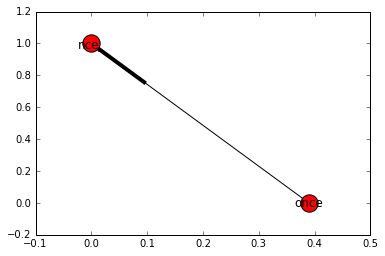

In [52]:
nx.draw_networkx(db_graph)

Add the other reads to the graph.

In [53]:
for read in reads[1:]:
    add_read(db_graph, read, k)

Draw the resulting graph.

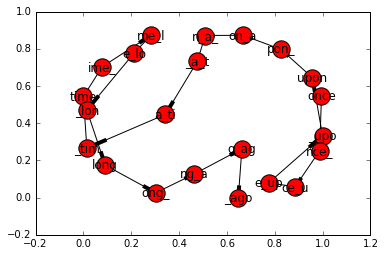

In [54]:
nx.draw_networkx(db_graph)

Define a function that finds the semi-balanced nodes in the graph, i.e., those that have an indegree that is one more, or one less than their outdegree.

In [55]:
def semi_balanced_nodes(graph):
    in_degrees, out_degrees = {}, {}
    for edge in graph.edges():
        if edge[0] not in out_degrees:
            in_degrees[edge[0]] = 0
            out_degrees[edge[0]] = 0
        out_degrees[edge[0]] += 1
        if edge[1] not in in_degrees:
            in_degrees[edge[1]] = 0
            out_degrees[edge[1]] = 0
        in_degrees[edge[1]] += 1
    semi_balanced = []
    for node in set(in_degrees) | set(out_degrees):
        if abs(in_degrees[node] - out_degrees[node]) == 1:
            semi_balanced.append((node, in_degrees[node], out_degrees[node]))
    return semi_balanced

If the graph is Eulerian, there should be two semi-balanced nodes, all orther nodes should be balanced.

In [56]:
semi_balanced = semi_balanced_nodes(db_graph)
semi_balanced

[('_ago', 1, 0), ('once', 0, 1)]

These are indeed the first and last $k-1$-mer of the string.  However, we can not rely on the order in which they are returned due the fact that the data structures used to store the graph's nodes are essentially a black box. Hence we explicitly define the first and the last $k-1$-mer.  This is easy to do since the left $k-1$-mer will have more outgoing than incoming edges, and vice versa for the right end.

In [59]:
def find_ends(graph):
    semi_balanced = semi_balanced_nodes(graph)
    left_ends = [x[0] for x in semi_balanced if x[1] < x[2]]
    right_ends = [x[0] for x in semi_balanced if x[1] > x[2]]
    if len(left_ends) != 1 or len(right_ends) != 1:
        print('problem detecting start and end', file=sys.stderr)
    else:
        return left_ends[0], right_ends[0]

In [60]:
start_k_1_mer, end_k_1_mer = find_ends(db_graph)
start_k_1_mer, end_k_1_mer

('once', '_ago')

Add an edge between the last and the first $k-1$-mer.

In [61]:
db_graph.add_edge(end_k_1_mer, start_k_1_mer)

In [63]:
for x in nx.eulerian_circuit(db_graph, source=start_k_1_mer):
    print(x)

('once', 'nce_')
('nce_', 'ce_u')
('ce_u', 'e_up')
('e_up', '_upo')
('_upo', 'upon')
('upon', 'pon_')
('pon_', 'on_a')
('on_a', 'n_a_')
('n_a_', '_a_t')
('_a_t', 'a_ti')
('a_ti', '_tim')
('_tim', 'time')
('time', 'ime_')
('ime_', 'me_l')
('me_l', 'e_lo')
('e_lo', '_lon')
('_lon', 'long')
('long', 'ong_')
('ong_', 'ng_a')
('ng_a', 'g_ag')
('g_ag', '_ago')
('_ago', 'once')


Define a function that computes the target string from the Euler circuit for the graph.

In [64]:
def assemble(graph, start_node):
    result_str = ''
    for edge in nx.eulerian_circuit(graph, start_node):
        result_str += edge[0][0]
    result_str += edge[0][1:]
    return result_str

In [65]:
assemble(db_graph, start_k_1_mer)

'once_upon_a_time_long_ago'